## This file includes implementation of methods used in our paper in Example С on SUSU dataset:
### 1- HybridCNN+MLP 
### 2- LPC-NN 
### 3- TDSIs-NN

# HybridCNN+MLP

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import glob
import PIL
import imageio
import seaborn as sn
import matplotlib.pyplot as plt

from numpy import savez_compressed
from PIL import Image
from scipy import misc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

from tensorflow.keras.layers import concatenate
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from IPython.display import HTML, display

## Functions

In [2]:
def results(history, model, testX, testY):
  plt.rc('axes',edgecolor='k')
  plt.rc('axes',linewidth='1')
  plt.rcParams['figure.dpi'] = 100
  dataset_labels=np.array(['Normal','Inner', 'Outer', 'Ball', 'Comb'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(history.history['loss']))
  plt.figure(figsize=(8, 5))
  plt.subplot(121, facecolor='w')
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(122, facecolor='w')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  

  test_loss, test_acc = model.evaluate(testX, testY, verbose=2)

  # Confusion Matrix
  predictions = model.predict(testX)
  confusion = confusion_matrix(np.argmax(testY, axis=1), 
                              np.argmax(predictions, axis=1))
  print('CONFUSION MATRIX\n', confusion, '\n\n')
  # normalize confustion matrix [0 1]
  # confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
  df_cm = pd.DataFrame(confusion, 
                       dataset_labels, 
                       dataset_labels)
  sn.set(font_scale=1.2) # for label size
  plt.figure(figsize=(4,4))
  sn.heatmap(df_cm, 
             annot=True, 
             annot_kws={"size": 10},
             fmt = "d",
             linewidths=.5,
             cmap="YlGnBu") 
  plt.title(str(model.name))
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()

  print('CLASSIFICATION REPORT\n',
        classification_report(np.argmax(testY, axis=1), 
                              np.argmax(predictions, axis=1), 
                              target_names=dataset_labels))

In [3]:
def progress(value, max=100):
  # Progress Bar
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 50%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [4]:
def load_signals_attributes(input_path, display=False):
  print('[INFO] Loading…\n')
  cols = ["N1", "N2", "class"]
  df = pd.read_csv(input_path, sep=" ", header=None, names=cols)
  print('[INFO] Attributes loaded successfully!\n')
  if display == True:
    df.head()
  return df

In [5]:
def load_signals_images(input_path):
  print(os.listdir(input_path))
  print('[INFO] Sorting files in directory...\n')
  path = input_path+"/*.png"
  directory = sorted(glob.glob(path), key=len) 
  directory = sorted(glob.glob(path), 
                    key=lambda x: int(os.path.basename(x).split('.')[0]))

  def get_key(fp):
      filename = os.path.splitext(os.path.basename(fp))[0]
      int_part = filename.split()[0]
      return int(int_part)
  directory = sorted(glob.glob(path), 
                    key=get_key)

  print('[INFO] Loading images in matrices...\n')
  Im = []
  bar = display(progress(0, len(directory)), display_id=True) # Progress Bar
  counter = 0
  for image_path in directory:
    img = imageio.imread(image_path)
    Im.append(img)
    counter += 1
    bar.update(progress(counter, len(directory))) # Update Progress
  # Масштабируем  
  Im = np.array(Im)/255.0
  print("[INFO] Dataset loaded")
  return Im

## Load dataset

### Main Data

In [6]:
data_root_Train='D:\\Mohammad paper\\LPC-NN\\to_submit_Trans_on_Ins_Meas\\CORRECTED\\data\\hilbert\\imagesTrain'
data_root_Test='D:\\Mohammad paper\\LPC-NN\\to_submit_Trans_on_Ins_Meas\\CORRECTED\\data\\hilbert\\imagesTest'

In [7]:
attr_Train = load_signals_attributes(data_root_Train+"/TxtInfo_Train.txt")
attr_Test = load_signals_attributes(data_root_Test+"/TxtInfo_Test.txt")

[INFO] Loading…

[INFO] Attributes loaded successfully!

[INFO] Loading…

[INFO] Attributes loaded successfully!



In [8]:
images_Train = load_signals_images(data_root_Train) # сырые картинки, которые будут нормализованы (нужно больше времени)
images_Test = load_signals_images(data_root_Test);

['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png', '1007.png', '1008.png', '1009.png', '101.png', '1010.png', '1011.png', '1012.png', '1013.png', '1014.png', '1015.png', '1016.png', '1017.png', '1018.png', '1019.png', '102.png', '1020.png', '1021.png', '1022.png', '1023.png', '1024.png', '1025.png', '1026.png', '1027.png', '1028.png', '1029.png', '103.png', '1030.png', '1031.png', '1032.png', '1033.png', '1034.png', '1035.png', '1036.png', '1037.png', '1038.png', '1039.png', '104.png', '1040.png', '1041.png', '1042.png', '1043.png', '1044.png', '1045.png', '1046.png', '1047.png', '1048.png', '1049.png', '105.png', '1050.png', '1051.png', '1052.png', '1053.png', '1054.png', '1055.png', '1056.png', '1057.png', '1058.png', '1059.png', '106.png', '1060.png', '1061.png', '1062.png', '1063.png', '1064.png', '1065.png', '1066.png', '1067.png', '1068.png', '1069.png', '107.png', '1070.png', '1071.png', '1072.png', '1073.png', '107

[INFO] Dataset loaded
['1.png', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '11.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '12.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127.png', '128.png', '129.png', '13.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '14.png', '140.png', '141.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '15.png', '150.png', '151.png', '152.png', '153.png', '154.png', '155.png', '156.png', '157.png', '158.png', '159.png', '16.png', '160.png', '161.png', '162.png', '163.png', '164.png', '165.png', '166.png', '167.png', '168.png', '169.png', '17.png', '170.png', '171.png', '172.png', '173.png', '174.png', '175.png', '176.png', '177.png', '178.png', '179.png', '18.png'

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Split

In [9]:

testAttrX=attr_Test
testImagesX=images_Test

AttrX=attr_Train
ImagesX=images_Train

split = train_test_split(AttrX, ImagesX, test_size=0.1, random_state=42)
(trainAttrX,validAttrX, trainImagesX, validImagesX) = split

trainAttrX

continuous = ["N1", "N2"]

# Normalizing data to be the interval [0 1]
cs = MinMaxScaler()
trainAttrXnorm = cs.fit_transform(trainAttrX[continuous])
validAttrXnorm = cs.fit_transform(validAttrX[continuous])
testAttrXnorm = cs.transform(testAttrX[continuous])

zipBinarizer = LabelBinarizer().fit(attr_Train["class"])
trainY = zipBinarizer.transform(trainAttrX["class"])
validY = zipBinarizer.transform(validAttrX["class"])

zipBinarizer = LabelBinarizer().fit(attr_Test["class"])
testY = zipBinarizer.transform(testAttrX["class"])

print(trainAttrX.shape)
print(validAttrX.shape)
print(testAttrX.shape)
print(trainImagesX.shape)
print(validImagesX.shape)
print(testImagesX.shape)



(1939, 3)
(216, 3)
(920, 3)
(1939, 32, 32, 3)
(216, 32, 32, 3)
(920, 32, 32, 3)


In [10]:
def create_mlp(dim, regress=False):
	model = Sequential()
	model.add(Dense(16, input_dim=dim, activation="relu"))
	model.add(Dense(8, activation="relu"))

	if regress:
		model.add(Dense(5))

	return model

In [11]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1

	# define the model input
	inputs = Input(shape=inputShape)

	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs

		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
    

	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x) 

	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(8)(x)
	x = Activation("relu")(x)

	# check to see if the regression node should be added
	if regress:
		x = Dense(5)(x)

	# construct the CNN
	model = Model(inputs, x)

	# return the CNN
	return model  

## Hybrid CNN + MLP_10 runs for average values of accuracy and time

In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
print('[INFO] Creating Hybrid CNN+MLP...')
mlp = create_mlp(trainAttrXnorm.shape[1], regress=False)
cnn = create_cnn(32, 32, 3, regress=False) 

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(8, activation="relu")(combinedInput)
x = Dense(5)(x)

checkpoint_path='hybrid1.h5'

keras_callbacks   = [
      EarlyStopping(monitor='val_accuracy', patience=10, verbose=1),
      ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)
]

model_mixed = Model(inputs=[mlp.input, cnn.input], 
                    outputs=x, 
                    name="Hybrid_CNN_MLP")

print('[INFO] Compiling model...')
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-3 / 200)
model_mixed.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(model_mixed.summary())


[INFO] Creating Hybrid CNN+MLP...
[INFO] Compiling model...
Model: "Hybrid_CNN_MLP"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 16)   448         ['input_4[0][0]']                
                                                                                                  
 activation_15 (Activation)     (None, 32, 32, 16)   0           ['conv2d_9[0][0]']               
                                                                                                  
 batch_normalization_12 (BatchN  (None, 32, 32, 16)  64          ['activation_15[0][0]']          
 ormalization)           

In [70]:
a=[]  # accuracy
t=[]  # time
checkpoint_path='hybrid1.h5'
for i in range(10):
    print('[INFO] Creating Hybrid CNN+MLP...')
    mlp = create_mlp(trainAttrXnorm.shape[1], regress=False)
    cnn = create_cnn(32, 32, 3, regress=False) 
    combinedInput = concatenate([mlp.output, cnn.output])
    x = Dense(8, activation="relu")(combinedInput)
    x = Dense(5)(x)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_accuracy', patience=100, verbose=1),
      ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)]

    model_mixed = Model(inputs=[mlp.input, cnn.input], 
                    outputs=x, 
                    name="Hybrid_CNN_MLP")
    print('[INFO] Compiling model...') 
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-3 / 200) 
    model_mixed.compile(optimizer=opt, 
                        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                        metrics=['accuracy'])
    # train the model
    print("[INFO] Training model...")
    import timeit
    start = timeit.default_timer()
    history_model_mixed = model_mixed.fit(
              x=[trainAttrXnorm, trainImagesX], y=trainY,
              validation_data=([validAttrXnorm, validImagesX], validY), 
              batch_size = 20,
              epochs=500,
              callbacks=[keras_callbacks])
    stop = timeit.default_timer()

    best_model_mixed = load_model(checkpoint_path)
    test_loss, test_acc = best_model_mixed.evaluate( [testAttrXnorm, testImagesX],  testY)
    
    a.append(test_acc)
    t.append(stop - start)

[INFO] Creating Hybrid CNN+MLP...
[INFO] Compiling model...
[INFO] Training model...
Epoch 1/500
97/97 [==============================] - 2s 14ms/step - loss: 1.7059 - accuracy: 0.2785 - val_loss: 1.5936 - val_accuracy: 0.1944
Epoch 2/500
97/97 [==============================] - 1s 11ms/step - loss: 1.4771 - accuracy: 0.3755 - val_loss: 1.5763 - val_accuracy: 0.2731
Epoch 3/500
97/97 [==============================] - 1s 11ms/step - loss: 1.3817 - accuracy: 0.4327 - val_loss: 1.5193 - val_accuracy: 0.3565
Epoch 4/500
97/97 [==============================] - 1s 11ms/step - loss: 1.3197 - accuracy: 0.4487 - val_loss: 1.4311 - val_accuracy: 0.3889
Epoch 5/500
97/97 [==============================] - 1s 10ms/step - loss: 1.2657 - accuracy: 0.4992 - val_loss: 1.2665 - val_accuracy: 0.6250
Epoch 6/500
97/97 [==============================] - 1s 11ms/step - loss: 1.1880 - accuracy: 0.5585 - val_loss: 1.1113 - val_accuracy: 0.7083
Epoch 7/500
97/97 [==============================] - 1s 10ms/st

In [71]:
t

[254.10808069999985,
 385.52748699999984,
 263.4961357000002,
 161.9845591000003,
 320.9273565000003,
 301.79611499999965,
 198.34180200000083,
 303.1207585000002,
 278.5458414000004,
 321.1469054999998]

In [72]:
a

[0.968478262424469,
 0.9510869383811951,
 0.945652186870575,
 0.960869550704956,
 0.969565212726593,
 0.9510869383811951,
 0.95652174949646,
 0.9554347991943359,
 0.959782600402832,
 0.957608699798584]

In [75]:
t1_1=np.mean(t) # average time
t1_1

278.89950414000015

In [76]:
a1_1=np.mean(a) # average accuracy
a1_1

0.9576086938381195

### Results (for last run)

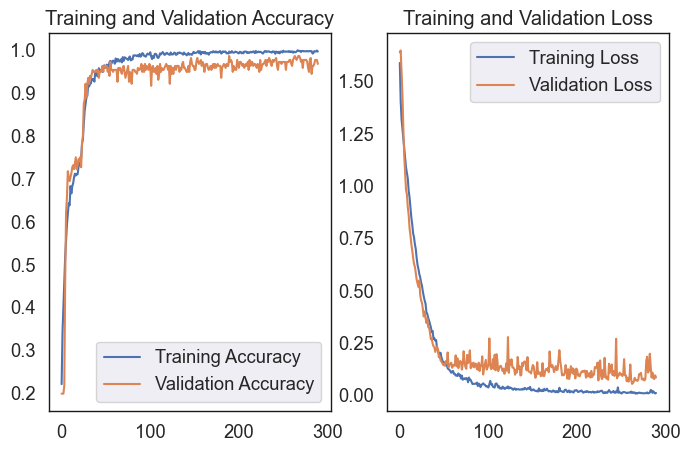

29/29 - 0s - loss: 0.1782 - accuracy: 0.9576 - 390ms/epoch - 13ms/step
29/29 [==============================] - 0s 8ms/step
CONFUSION MATRIX
 [[184   0   0   0   0]
 [  0 180   0   1   3]
 [  0   0 182   1   1]
 [  0   9   9 166   0]
 [  0   3   4   8 169]] 




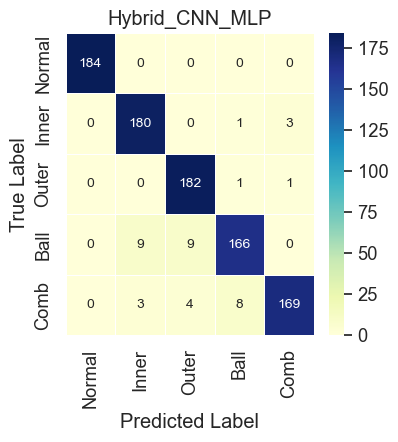

CLASSIFICATION REPORT
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       184
       Inner       0.94      0.98      0.96       184
       Outer       0.93      0.99      0.96       184
        Ball       0.94      0.90      0.92       184
        Comb       0.98      0.92      0.95       184

    accuracy                           0.96       920
   macro avg       0.96      0.96      0.96       920
weighted avg       0.96      0.96      0.96       920



In [78]:
from tensorflow.keras.models import load_model
best_model_mixed = load_model(checkpoint_path)


results(history_model_mixed, 
        best_model_mixed, 
        [testAttrXnorm, testImagesX], 
        testY)

In [198]:
a=[]  # accuracy
t=[]  # time
checkpoint_path='hybrid1.h5'
for i in range(10):
    print('[INFO] Creating Hybrid CNN+MLP...')
    mlp = create_mlp(trainAttrXnorm10.shape[1], regress=False)
    cnn = create_cnn(32, 32, 3, regress=False) 
    combinedInput = concatenate([mlp.output, cnn.output])
    x = Dense(8, activation="relu")(combinedInput)
    x = Dense(5)(x)
    
    keras_callbacks   = [
      EarlyStopping(monitor='val_accuracy', patience=100, verbose=1),
      ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)]

    model_mixed = Model(inputs=[mlp.input, cnn.input], 
                    outputs=x, 
                    name="Hybrid_CNN_MLP")
    print('[INFO] Compiling model...') 
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-3 / 200) 
    model_mixed.compile(optimizer=opt, 
                        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                        metrics=['accuracy'])
    # train the model
    print("[INFO] Training model...")
    import timeit
    start = timeit.default_timer()
    history_model_mixed = model_mixed.fit(
              x=[trainAttrXnorm10, trainImagesX10], y=trainY10,
              validation_data=([validAttrXnorm10, validImagesX10], validY10), 
              batch_size = 20,
              epochs=500,
              callbacks=[keras_callbacks])
    stop = timeit.default_timer()

    best_model_mixed = load_model(checkpoint_path)
    test_loss, test_acc = best_model_mixed.evaluate( [testAttrXnorm, testImagesX],  testY)
    
    a.append(test_acc)
    t.append(stop - start)

[INFO] Creating Hybrid CNN+MLP...
[INFO] Compiling model...
[INFO] Training model...
Epoch 1/500
27/27 [==============================] - 2s 31ms/step - loss: 1.8962 - accuracy: 0.0667 - val_loss: 1.6371 - val_accuracy: 0.0746
Epoch 2/500
27/27 [==============================] - 1s 20ms/step - loss: 1.7100 - accuracy: 0.1000 - val_loss: 1.6741 - val_accuracy: 0.0746
Epoch 3/500
27/27 [==============================] - 1s 20ms/step - loss: 1.6670 - accuracy: 0.0870 - val_loss: 1.6782 - val_accuracy: 0.0746
Epoch 4/500
27/27 [==============================] - 1s 20ms/step - loss: 1.6450 - accuracy: 0.0907 - val_loss: 1.6917 - val_accuracy: 0.0746
Epoch 5/500
27/27 [==============================] - 1s 24ms/step - loss: 1.6171 - accuracy: 0.1093 - val_loss: 1.6903 - val_accuracy: 0.0896
Epoch 6/500
27/27 [==============================] - 1s 21ms/step - loss: 1.5818 - accuracy: 0.1444 - val_loss: 1.6706 - val_accuracy: 0.0896
Epoch 7/500
27/27 [==============================] - 1s 20ms/st

In [199]:
t

[118.91883019999841,
 147.15418639999916,
 151.3564425000004,
 103.94854560000022,
 136.00367320000078,
 143.1594798999995,
 120.86176509999859,
 91.4291787000002,
 144.41090879999865,
 122.60984179999832]

In [200]:
a

[0.7782608866691589,
 0.845652163028717,
 0.841304361820221,
 0.813043475151062,
 0.7565217614173889,
 0.79347825050354,
 0.841304361820221,
 0.699999988079071,
 0.845652163028717,
 0.748913049697876]

In [201]:
t1_10=np.mean(t) # average time
t1_10

127.98528521999943

In [202]:
a1_10=np.mean(a) # average accuracy
a1_10

0.7964130461215972

### End of HybridCNN+MLP

# LPC-NN

## Loading Data

In [223]:
root_folder_="D:\\Mohammad paper\\LPC-NN\\to_submit_Trans_on_Ins_Meas\\CORRECTED\\data\\lpc\\CSV\\";

In [224]:
from sklearn.utils import shuffle
# Path to train
path_to_train=root_folder_+"Z_0_TRAIN_70_STEP_2500_OVERLAP_50_PERCERNT_LPC_50_.csv"


#Loading training data
data_raw = pd.read_csv(path_to_train,header=None)
data_raw

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,1,-1.1882,0.45501,-0.24350,0.064977,0.003803,-0.030387,-0.018263,-0.032903,0.008215,...,0.012128,0.009543,-0.000238,-0.001693,0.023079,0.011074,0.012264,0.024563,-0.024277,1
1,1,-1.1747,0.46731,-0.24488,0.067928,-0.001249,-0.041066,-0.049452,0.009204,0.018806,...,0.003182,0.015661,-0.027561,0.025756,0.031766,0.005893,0.016709,0.012947,-0.010429,1
2,1,-1.1939,0.46652,-0.24324,0.045133,0.037782,-0.073964,-0.030209,0.019220,0.017296,...,-0.009377,0.023592,-0.033212,0.036464,0.010720,0.011301,0.007843,0.022704,-0.015868,1
3,1,-1.2141,0.51752,-0.29823,0.093176,0.048646,-0.081795,-0.025413,-0.003962,0.017245,...,-0.015432,0.019323,-0.018596,0.030259,-0.003972,0.039241,-0.008951,0.027268,-0.010254,1
4,1,-1.2318,0.56214,-0.35028,0.126910,0.015878,-0.016951,-0.083535,0.023411,-0.002820,...,-0.009512,0.010308,-0.029536,0.042919,-0.011677,0.053403,-0.010465,0.025847,-0.013370,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,1,-1.4540,0.91214,-0.42414,0.153950,-0.062926,0.138680,-0.365820,0.234460,0.086976,...,-0.000473,-0.099319,0.034728,-0.010073,0.066307,-0.023049,0.042467,0.025965,0.034108,5
2151,1,-1.4459,0.96853,-0.50716,0.186040,-0.066022,0.105940,-0.329610,0.248560,0.059083,...,-0.054845,-0.022686,-0.009512,0.016065,0.028363,0.024959,-0.012643,0.052826,0.039675,5
2152,1,-1.3385,0.76229,-0.32220,0.054202,0.030506,0.011325,-0.248430,0.116820,0.178150,...,-0.057604,-0.029538,-0.024799,0.026363,0.002584,0.056143,-0.045662,0.067982,0.031014,5
2153,1,-1.3624,0.79442,-0.33862,0.053516,0.078665,-0.029010,-0.234540,0.122320,0.165670,...,-0.052991,-0.031515,-0.027306,0.036034,-0.006137,0.049593,-0.009802,0.034697,0.041619,5


In [225]:
data = data_raw.iloc[np.random.permutation(len(data_raw))]
labels=data.iloc[:,51]
features = data.iloc[:,1:51]
X=features
y=np.ravel(labels)
X_train, y_train = shuffle(X, y)
print(X_train.shape)

(2155, 50)


In [226]:
# Path to test
path_to_test=root_folder_+"Z_0_TEST_70_STEP_2500_OVERLAP_50_PERCERNT_LPC_50_.csv"

#Loading testing data
data12 = pd.read_csv(path_to_test,header=None)
labels12=data12.iloc[:,51]
features12 = data12.iloc[:,1:51]
X12=features12
y12=np.ravel(labels12)
X_test=X12;
y_test=y12;

In [227]:
myN=5; #number of classes

from keras.utils import np_utils
y_train=y_train-1;
y_test=y_test-1;
# Convert to categorical
Y_train = np_utils.to_categorical(y_train, myN) 
Y_test = np_utils.to_categorical(y_test, myN)
Y_test.shape

(920, 5)

In [228]:
model_name='bestmodel_0_0_LPC_NN'
confusion_title="Confusion matrix of SUSU dataset"

## LPC-NN_10 runs

In [242]:
import timeit
# Number of classes
myN=5;

# Buidling neural network model
def build_my_model(numberOfClasses):
    model = Sequential()
    model.add(Dense(50, input_dim=50, activation="tanh"))
    model.add(Dense(numberOfClasses))
    #model.add(Dense(numberOfClasses, activation="softmax"))
    #model.compile(loss="categorical_crossentropy",optimizer='adam', metrics=["accuracy"]) 
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-3 / 200)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
   # print(model.summary())
    return model;


t=[]
a=[]
for i in range(10): 
    print(i)
    checkpoint_path='model_name'
    keras_callbacks   = [EarlyStopping(monitor='val_accuracy', patience=100, verbose=1),
                         ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)
                        ]
    model=build_my_model(myN);
    
    
    start = timeit.default_timer()
    history=model.fit(X_train, Y_train,epochs=500, batch_size=27, verbose=1, validation_split=0.1,callbacks=[keras_callbacks])
    best_model = load_model(checkpoint_path)
    model=best_model;
    stop = timeit.default_timer()
    
    
    t.append(stop - start)
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2) 
    a.append(test_acc)


0
Epoch 1/500
72/72 [==============================] - 1s 10ms/step - loss: 1.6285 - accuracy: 0.1315 - val_loss: 1.6080 - val_accuracy: 0.1991
Epoch 2/500
72/72 [==============================] - 1s 12ms/step - loss: 1.5908 - accuracy: 0.2656 - val_loss: 1.5746 - val_accuracy: 0.2870
Epoch 3/500
72/72 [==============================] - 1s 8ms/step - loss: 1.5551 - accuracy: 0.3641 - val_loss: 1.5420 - val_accuracy: 0.3981
Epoch 4/500
72/72 [==============================] - 1s 8ms/step - loss: 1.5207 - accuracy: 0.4905 - val_loss: 1.5100 - val_accuracy: 0.5231
Epoch 5/500
72/72 [==============================] - 1s 8ms/step - loss: 1.4869 - accuracy: 0.5596 - val_loss: 1.4776 - val_accuracy: 0.5787
Epoch 6/500
72/72 [==============================] - 1s 11ms/step - loss: 1.4529 - accuracy: 0.6003 - val_loss: 1.4449 - val_accuracy: 0.6111
Epoch 7/500
72/72 [==============================] - 1s 8ms/step - loss: 1.4188 - accuracy: 0.6436 - val_loss: 1.4116 - val_accuracy: 0.6481
Epoch 8/

In [243]:
t

[17.173428899999635,
 21.12407229999917,
 17.7957374000016,
 16.680735599999025,
 18.95711130000018,
 17.448785500000668,
 15.859291799999482,
 17.289060200000677,
 19.260718699999416,
 15.282274999999572]

In [244]:
a

[0.9934782385826111,
 0.998913049697876,
 0.97826087474823,
 0.9967391490936279,
 0.997826099395752,
 1.0,
 0.981521725654602,
 1.0,
 1.0,
 0.9836956262588501]

In [245]:
t2_1=np.mean(t) # average time
t2_1

17.687121669999943

In [246]:
a2_1=np.mean(a) # average accuracy
a2_1

0.9930434763431549

## Results (for last run)

In [247]:
scores = model.evaluate(X_test, Y_test, verbose=2) 
print(scores)

29/29 - 0s - loss: 1.0394 - accuracy: 0.9837 - 27ms/epoch - 932us/step
[1.0394160747528076, 0.9836956262588501]


C:\Users\PC1\AppData\Local\Temp\ipykernel_18564\1357602405.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)
C:\Users\PC1\AppData\Local\Temp\ipykernel_18564\1357602405.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


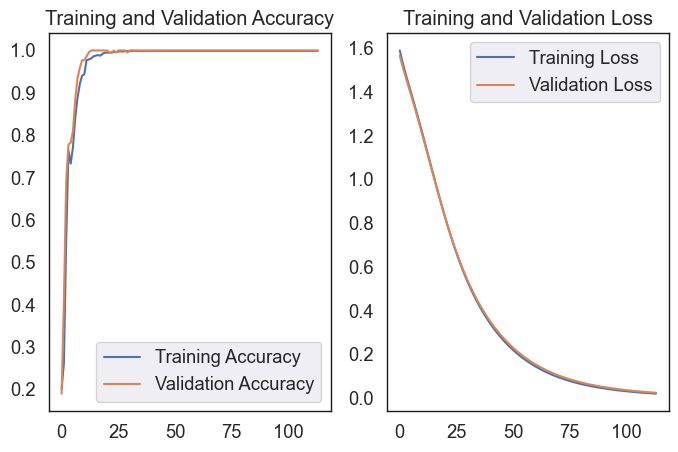

29/29 [==============================] - 0s 909us/step
CLASSIFICATION REPORT
               precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       184
       Inner       1.00      0.92      0.96       184
       Outer       0.99      1.00      1.00       184
        Ball       1.00      1.00      1.00       184
        Comb       0.93      1.00      0.96       184

    accuracy                           0.98       920
   macro avg       0.98      0.98      0.98       920
weighted avg       0.98      0.98      0.98       920



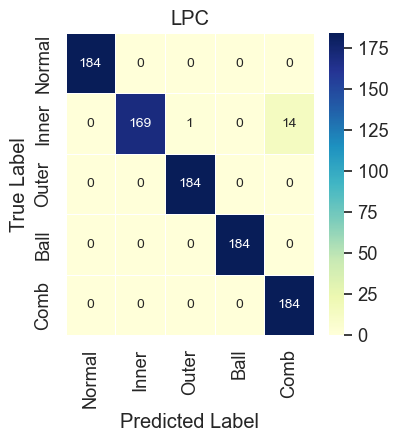

In [248]:
# Plot Training and Validation Accuracy and  Training and Validation Loss
plt.rc('axes',edgecolor='k')
plt.rc('axes',linewidth='1')


plt.rcParams['figure.dpi'] = 100
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 5))
plt.subplot(121, facecolor='w')
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(b=None)

plt.subplot(122, facecolor='w')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.grid(b=None)
plt.show()

# Draw confusion matrix (It is only for the last trial)
predictions=model.predict(X_test);
confusion=confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(predictions,axis=1));

dataset_labels=np.array(['Normal','Inner','Outer','Ball','Comb'])
##
df_cm = pd.DataFrame(confusion, 
              dataset_labels, 
              dataset_labels)

sn.set(font_scale=1.2) # for label size
plt.figure(figsize=(4,4))
sn.heatmap(df_cm,annot=True,annot_kws={"size": 10},fmt = "d",linewidths=.5,cmap="YlGnBu") 
plt.title('LPC')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# Print classification report
print('CLASSIFICATION REPORT\n',
  classification_report(np.argmax(Y_test, axis=1), 
                        np.argmax(predictions, axis=1), 
                        target_names=dataset_labels))



#### The end of LPC-NN

# TDSIs-NN

In [3]:
root_folder_= r'D:\Mohammad paper\LPC-NN\to_submit_Trans_on_Ins_Meas\CORRECTED\cor_moh\TDSIs';

# Path to train
path_to_train=root_folder_+"\SUSU_TDSIs_TRAIN.csv"

#Loading training data
data_raw1 = pd.read_csv(path_to_train)
data_raw=data_raw1.drop(['SIANA'], axis=1)
data_raw=data_raw.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

data_raw


,PEAK,RMS_,CF,KUR,IF,SF,TALAF,THIKAT,KUCR,INTHAR,Status
0,512.27,212.32,2.4127,2.3997,2.9683,1.2303,1.2387,25.723,3.4921,-170.94,1
1,515.45,213.44,2.4149,2.4688,3.0085,1.2458,1.2601,28.598,3.5512,-171.67,1
2,515.45,207.33,2.4862,2.5111,3.0966,1.2455,1.2635,13.612,3.5808,-172.01,1
3,584.25,208.89,2.7969,2.5036,3.4467,1.2323,1.2636,19.820,3.8262,-197.66,1
4,584.25,207.61,2.8142,2.7092,3.5088,1.2468,1.3184,16.223,3.9638,-196.29,1
...,...,...,...,...,...,...,...,...,...,...,...
2150,687.79,225.74,3.0468,2.6194,3.7279,1.2235,1.3184,76.687,4.2969,-233.07,5
2151,691.38,229.10,3.0178,2.6783,3.7249,1.2343,1.3384,87.305,4.3471,-234.22,5
2152,740.42,228.85,3.2353,2.9012,4.0912,1.2645,1.3949,92.695,4.6758,-248.13,5
2153,740.42,237.47,3.1180,2.9547,3.9944,1.2811,1.4185,120.050,4.7091,-249.14,5


In [6]:
from sklearn.utils import shuffle
data = data_raw.iloc[np.random.permutation(len(data_raw))]
features=data[['PEAK','RMS_','CF','KUR','IF','SF','TALAF','THIKAT','KUCR','INTHAR']]
labels = data['Status']
X=features
y=np.ravel(labels)
X_train, y_train = shuffle(X, y)
print(X_train.shape)

(2143, 10)


In [7]:
# Path to test
path_to_test=root_folder_+"\SUSU_TDSIs_TEST.csv"

#Loading testing data
data12 = pd.read_csv(path_to_test)
data12=data12.drop(['SIANA'], axis=1)
data12=data12.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

labels12=data12['Status']
features12 = data12[['PEAK','RMS_','CF','KUR','IF','SF','TALAF','THIKAT','KUCR','INTHAR']]

X12=features12
y12=np.ravel(labels12)
X_test=X12;
y_test=y12;

In [9]:
from keras.utils import np_utils
myN=5; #number of classes

y_train=y_train-1;
y_test=y_test-1;
# Convert to categorical
Y_train = np_utils.to_categorical(y_train, myN) 
Y_test = np_utils.to_categorical(y_test, myN)
Y_test.shape

(914, 5)

In [10]:
cs = MinMaxScaler()
X_train = cs.fit_transform(X_train)
X_test = cs.transform(X_test)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import timeit
# Buidling neural network model
def build_my_model(numberOfClasses):
    model = Sequential()
    model.add(Dense(30, input_dim=10,  activation="tanh"))
    model.add(Dense(20,  activation="tanh"))
    model.add(Dense(numberOfClasses))
 
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-3 / 200)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
   # print(model.summary())
    return model;


tSTAT_NN=[]
aSTAT_NN=[]
for i in range(10): 
    print(i)
    checkpoint_path='bestmodel_0_0_STAT_NN.h5'
    keras_callbacks   = [EarlyStopping(monitor='val_accuracy', patience=100, verbose=1),
                         ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)
                        ]
    model=build_my_model(myN);
    
    
    start = timeit.default_timer()
    history=model.fit(X_train, Y_train, epochs=500, batch_size=27, verbose=1, validation_split=0.1,callbacks=[keras_callbacks])
    best_model = load_model(checkpoint_path)
    model=best_model;
    stop = timeit.default_timer()
    
    
    tSTAT_NN.append(stop - start)
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2) 
    aSTAT_NN.append(test_acc)


0
Epoch 1/500
72/72 [==============================] - 0s 3ms/step - loss: 1.5413 - accuracy: 0.2505 - val_loss: 1.4422 - val_accuracy: 0.3628
Epoch 2/500
72/72 [==============================] - 0s 1ms/step - loss: 1.3880 - accuracy: 0.4134 - val_loss: 1.3020 - val_accuracy: 0.4651
Epoch 3/500
72/72 [==============================] - 0s 797us/step - loss: 1.2854 - accuracy: 0.4445 - val_loss: 1.2330 - val_accuracy: 0.4651
Epoch 4/500
72/72 [==============================] - 0s 1ms/step - loss: 1.2341 - accuracy: 0.4652 - val_loss: 1.2026 - val_accuracy: 0.4791
Epoch 5/500
72/72 [==============================] - 0s 1ms/step - loss: 1.2078 - accuracy: 0.4710 - val_loss: 1.1777 - val_accuracy: 0.4930
Epoch 6/500
72/72 [==============================] - 0s 923us/step - loss: 1.1829 - accuracy: 0.4907 - val_loss: 1.1630 - val_accuracy: 0.4930
Epoch 7/500
72/72 [==============================] - 0s 1ms/step - loss: 1.1606 - accuracy: 0.5067 - val_loss: 1.1403 - val_accuracy: 0.5256
Epoch 8

In [38]:
print(np.mean(aSTAT_NN))
print(np.mean(tSTAT_NN))

0.7683807432651519
25.271336999999903


C:\Users\PC1\AppData\Local\Temp\ipykernel_14584\3171291920.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)
C:\Users\PC1\AppData\Local\Temp\ipykernel_14584\3171291920.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


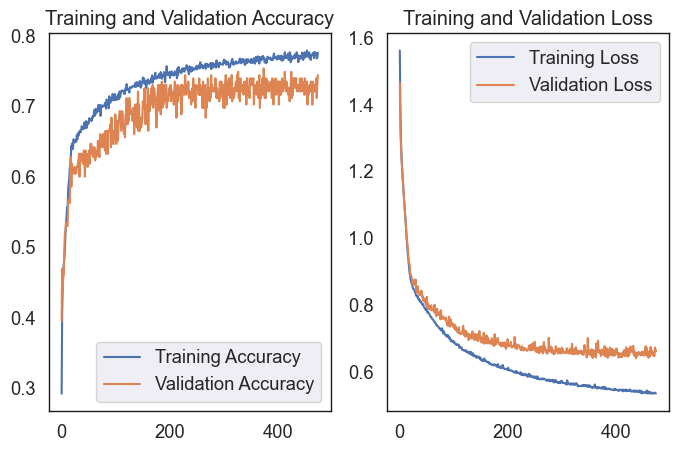

29/29 [==============================] - 0s 489us/step
CLASSIFICATION REPORT
               precision    recall  f1-score   support

      Normal       0.69      0.72      0.70       184
       Inner       0.84      0.88      0.86       178
       Outer       0.82      0.74      0.78       184
        Ball       0.73      0.66      0.70       184
        Comb       0.80      0.88      0.84       184

    accuracy                           0.78       914
   macro avg       0.78      0.78      0.77       914
weighted avg       0.78      0.78      0.77       914



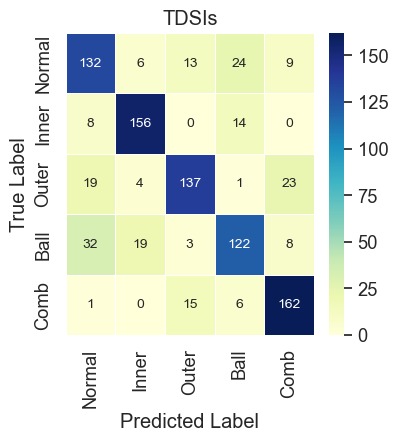

In [41]:
# Plot Training and Validation Accuracy and  Training and Validation Loss
plt.rc('axes',edgecolor='k')
plt.rc('axes',linewidth='1')


plt.rcParams['figure.dpi'] = 100
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 5))
plt.subplot(121, facecolor='w')
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(b=None)

plt.subplot(122, facecolor='w')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.grid(b=None)
plt.show()

# Draw confusion matrix (It is only for the last trial)
predictions=model.predict(X_test);
confusion=confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(predictions,axis=1));

dataset_labels=np.array(['Normal','Inner','Outer','Ball','Comb'])
##
df_cm = pd.DataFrame(confusion, 
              dataset_labels, 
              dataset_labels)

sn.set(font_scale=1.2) # for label size
plt.figure(figsize=(4,4))
sn.heatmap(df_cm,annot=True,annot_kws={"size": 10},fmt = "d",linewidths=.5,cmap="YlGnBu") 
plt.title('TDSIs')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# Print classification report
print('CLASSIFICATION REPORT\n',
  classification_report(np.argmax(Y_test, axis=1), 
                        np.argmax(predictions, axis=1), 
                        target_names=dataset_labels))



#### The end of TDSIs-NN